# Analysis of Transcriptome Datasets from GEO Database

This notebook demonstrates how to analyze transcriptome datasets from the Gene Expression Omnibus (GEO) database. We'll cover:

1. Downloading data from GEO
2. Data preprocessing and quality control
3. Differential expression analysis
4. Visualization of results
5. Pathway analysis

## Requirements
We'll use several Python packages for bioinformatics analysis:
- GEOparse: for downloading GEO datasets
- pandas: for data manipulation
- numpy: for numerical operations
- scipy: for statistical analysis
- limma: for differential expression analysis
- plotly/seaborn: for visualization

In [1]:
# Import required libraries
import GEOparse
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('default')  # Using default style instead of seaborn
sns.set_style("whitegrid")

## Download and Parse GSE167523

GSE167523 is a dataset that contains RNA-seq data from COVID-19 patients. Let's download and process this dataset using GEOparse.

In [2]:
# Download the GEO dataset
# This may take a few minutes depending on the dataset size
gse = GEOparse.get_GEO(geo="GSE167523")

16-Sep-2025 23:18:04 DEBUG utils - Directory ./ already exists. Skipping.
16-Sep-2025 23:18:04 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/soft/GSE167523_family.soft.gz to ./GSE167523_family.soft.gz
100%|██████████| 7.54k/7.54k [00:00<00:00, 35.0kB/s]
16-Sep-2025 23:18:05 DEBUG downloader - Size validation passed
16-Sep-2025 23:18:05 DEBUG downloader - Moving C:\Users\ychao\AppData\Local\Temp\tmpst8t7eii to c:\Users\ychao\OneDrive\Documents\Python Scripts\MASH\GSE167523_family.soft.gz
16-Sep-2025 23:18:05 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/soft/GSE167523_family.soft.gz
16-Sep-2025 23:18:05 INFO GEOparse - Parsing ./GSE167523_family.soft.gz: 
16-Sep-2025 23:18:05 DEBUG GEOparse - DATABASE: GeoMiame
16-Sep-2025 23:18:05 DEBUG GEOparse - SERIES: GSE167523
16-Sep-2025 23:18:05 DEBUG GEOparse - PLATFORM: GPL21290
16-Sep-2025 23:18:05 DEBUG GEOparse - SAMPLE: GSM5106590
16-Sep-2025 23:

## Examine the Dataset Structure

Let's look at the metadata and structure of our downloaded dataset.

In [8]:
# Display basic information about the dataset
print("Dataset information:")
print("-" * 50)
print(f"Title: {gse.get_metadata_attribute('title')}")
print(f"Description: {gse.get_metadata_attribute('summary')}")
print(f"Number of samples: {len(gse.gsms)}")

# Get the names of all samples
print("\nSample names:")
print("-" * 50)
for gsm_name, gsm in list(gse.gsms.items())[:5]:  # Show first 5 samples
    print(f"{gsm_name}: {gsm.metadata.get('title', ['No title'])[0]}")

Dataset information:
--------------------------------------------------
Title: Transcriptome profiling of human non-alcoholic fatty liver disease
Description: ['Nonalcoholic fatty liver disease (NAFLD) is the most common liver disease worldwide. Nonalcoholic steatohepatitis (NASH), the progressive form of NAFLD, and advanced fibrosis are associated with poor outcomes but their molecular pathogenesis is not fully elucidated.', 'Global RNA sequencing of snap frozen liver tissue from 98 patients with biopsy-proven NAFLD was performed.', 'Unsupervised hierarchical clustering well-distinguished NASH from NAFL, and NASH patients exhibited molecular abnormalities reflecting their pathological features. Transcriptomic analysis identified multiple secreted proteins upregulated in NASH and/or advanced fibrosis']
Number of samples: 98

Sample names:
--------------------------------------------------
GSM5106590: NAFLD liver 1
GSM5106591: NAFLD liver 2
GSM5106592: NAFLD liver 3
GSM5106593: NAFLD li

## Prepare Expression Data Matrix

First, we'll extract the expression data and sample information, then normalize the data for analysis.

In [5]:
# Extract expression data and sample information
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.multitest as multi

# Get the first GPL platform (assuming it's the main one)
gpl = next(iter(gse.gpls.values()))

# Create a sample info dataframe
sample_info = pd.DataFrame([
    {
        'sample_id': gsm_name,
        'title': gsm.metadata['title'][0],
        'characteristics_ch1': gsm.metadata.get('characteristics_ch1', [''])[0],
        'source_name_ch1': gsm.metadata.get('source_name_ch1', [''])[0]
    }
    for gsm_name, gsm in gse.gsms.items()
])

# Display sample information columns
print("Sample metadata columns:")
print(sample_info.columns)
print("\nSample characteristics example:")
print(sample_info['characteristics_ch1'].iloc[0])
print("\nSource name example:")
print(sample_info['source_name_ch1'].iloc[0])

Sample metadata columns:
Index(['sample_id', 'title', 'characteristics_ch1', 'source_name_ch1'], dtype='object')

Sample characteristics example:
tissue: liver biopsy

Source name example:
Liver


In [6]:
# Get the expression data from the first GSM (sample)
first_gsm = next(iter(gse.gsms.values()))
expression_data = pd.DataFrame()

for gsm_name, gsm in gse.gsms.items():
    sample_data = pd.DataFrame(list(zip(gsm.table['ID_REF'], gsm.table['VALUE'])),
                             columns=['gene_id', gsm_name])
    if expression_data.empty:
        expression_data = sample_data
    else:
        expression_data = expression_data.merge(sample_data, on='gene_id', how='outer')

# Set gene_id as index
expression_data = expression_data.set_index('gene_id')

# Display the shape of the expression matrix
print("Expression matrix shape (genes × samples):", expression_data.shape)
print("\nFirst few rows of expression data:")
print(expression_data.head())

KeyError: 'ID_REF'

In [7]:
# Examine the structure of the first sample's data
first_gsm = next(iter(gse.gsms.values()))
print("Available columns in the table:")
print(first_gsm.table.columns)
print("\nFirst few rows of the table:")
print(first_gsm.table.head())

Available columns in the table:
RangeIndex(start=0, stop=0, step=1)

First few rows of the table:
Empty DataFrame
Columns: []
Index: []


## Download Supplementary Data

For this dataset, the expression data is stored in supplementary files. Let's download and process these files.

In [3]:
# Download dataset files
import os
from urllib.request import urlretrieve

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data')

# Create data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the files
files_to_download = {
    'family': 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/soft/GSE167523_family.soft.gz',
    'counts': 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/suppl/GSE167523_Raw_gene_counts_matrix.txt.gz',
    'phenotype': 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/suppl/GSE167523_Sample_phenotype_correspondence.xlsx'
}

for file_type, url in files_to_download.items():
    file_name = url.split('/')[-1]
    file_path = os.path.join(data_dir, file_name)
    if not os.path.exists(file_path):
        print(f"Downloading {file_type} file...")
        urlretrieve(url, file_path)
        print(f"Downloaded {file_path}")
    else:
        print(f"{file_type} file already exists at {file_path}")

print("\nContents of data directory:")
print(os.listdir(data_dir))

family file already exists at c:\Users\ychao\OneDrive\Documents\Python Scripts\MASH\data\GSE167523_family.soft.gz
counts file already exists at c:\Users\ychao\OneDrive\Documents\Python Scripts\MASH\data\GSE167523_Raw_gene_counts_matrix.txt.gz
phenotype file already exists at c:\Users\ychao\OneDrive\Documents\Python Scripts\MASH\data\GSE167523_Sample_phenotype_correspondence.xlsx

Contents of data directory:
['GSE167523_family.soft.gz', 'GSE167523_Raw_gene_counts_matrix.txt.gz', 'GSE167523_Sample_phenotype_correspondence.xlsx']


In [12]:
# Print metadata to find supplementary files
print("Series metadata:")
for key, value in gse.metadata.items():
    if 'suppl' in key.lower():
        print(f"\n{key}:")
        for item in value:
            print(item)

Series metadata:

supplementary_file:
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/suppl/GSE167523_RAW.tar
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/suppl/GSE167523_Raw_gene_counts_matrix.txt.gz
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167523/suppl/GSE167523_Sample_phenotype_correspondence.xlsx


## Load and Process Data

Now we'll:
1. Load the gene expression data
2. Load the phenotype information
3. Prepare the data for differential expression analysis

In [4]:
# Load the gene expression data
import pandas as pd
import gzip

# Load gene expression data
counts_file = os.path.join(data_dir, 'GSE167523_Raw_gene_counts_matrix.txt.gz')
with gzip.open(counts_file, 'rt') as f:
    expression_data = pd.read_csv(f, sep='\t', index_col=0)

# Load phenotype data
phenotype_file = os.path.join(data_dir, 'GSE167523_Sample_phenotype_correspondence.xlsx')
phenotype_data = pd.read_excel(phenotype_file)

print("Expression data shape:", expression_data.shape)
print("\nFirst few rows of expression data:")
print(expression_data.head())
print("\nPhenotype data columns:")
print(phenotype_data.columns)
print("\nFirst few rows of phenotype data:")
print(phenotype_data.head())

Expression data shape: (26364, 98)

First few rows of expression data:
           NAFLD01  NAFLD02  NAFLD03  NAFLD04  NAFLD05  NAFLD06  NAFLD07  \
Gene                                                                       
DDX11L1          0        0        0        0        0        0        0   
WASH7P          14        6       12        6        1        8        2   
MIR6859-3        0        0        0        0        0        0        0   
MIR6859-2        0        0        0        0        0        0        0   
MIR6859-4        0        0        0        0        0        0        0   

           NAFLD08  NAFLD09  NAFLD10  ...  NAFLD89  NAFLD90  NAFLD91  NAFLD92  \
Gene                                  ...                                       
DDX11L1          0        0        0  ...        0        0        0        0   
WASH7P           4        8        6  ...        3        8        4        1   
MIR6859-3        0        0        0  ...        0        0        0    

In [5]:
# Prepare data for differential expression analysis

# Create a mapping between GEO accession IDs and phenotype
phenotype_mapping = dict(zip(phenotype_data['GEO accession ID'], phenotype_data['NAFL/NASH']))

# Rename columns to match GEO accession IDs
column_mapping = {f'NAFLD{i:02d}': acc_id 
                 for i, acc_id in enumerate(phenotype_data['GEO accession ID'], 1)}
expression_data = expression_data.rename(columns=column_mapping)

# Add phenotype information to each sample
sample_groups = pd.Series({sample: phenotype_mapping[sample] 
                          for sample in expression_data.columns})

print("Number of samples in each group:")
print(sample_groups.value_counts())

# Filter low expression genes
min_counts = 10  # Minimum count threshold
min_samples = 5  # Minimum number of samples that must exceed the threshold

# Count samples exceeding threshold for each gene
samples_above_threshold = (expression_data >= min_counts).sum(axis=1)
expressed_genes = samples_above_threshold >= min_samples

# Filter expression data
filtered_expression = expression_data.loc[expressed_genes]

print("\nExpression data shape before filtering:", expression_data.shape)
print("Expression data shape after filtering:", filtered_expression.shape)

Number of samples in each group:
NAFL    51
NASH    47
Name: count, dtype: int64

Expression data shape before filtering: (26364, 98)
Expression data shape after filtering: (15421, 98)


## Differential Expression Analysis

We'll use the following steps for differential expression analysis:
1. Normalize the count data
2. Perform statistical testing using limma-voom
3. Apply multiple testing correction
4. Identify significantly differentially expressed genes

In [10]:
# Perform differential expression analysis
from scipy import stats
import numpy as np
import statsmodels.stats.multitest as multi

def perform_de_analysis(expression_data, sample_groups):
    results = []
    
    for gene in expression_data.index:
        try:
            # Get expression values for the gene
            nafl_expr = expression_data.loc[gene, sample_groups == 'NAFL'].astype(float).values
            nash_expr = expression_data.loc[gene, sample_groups == 'NASH'].astype(float).values
            
            # Skip genes with invalid data
            if len(nafl_expr) == 0 or len(nash_expr) == 0:
                continue
            
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(nash_expr, nafl_expr, equal_var=False)
            
            # Calculate fold change
            mean_nafl = np.mean(nafl_expr)
            mean_nash = np.mean(nash_expr)
            log2_fold_change = np.log2((mean_nash + 1) / (mean_nafl + 1))
            
            results.append({
                'gene': gene,
                'log2FoldChange': log2_fold_change,
                'pvalue': p_val,
                'mean_NAFL': mean_nafl,
                'mean_NASH': mean_nash,
                't_statistic': t_stat
            })
        except Exception as e:
            print(f"Error processing gene {gene}: {str(e)}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        # Add adjusted p-values
        results_df['padj'] = multi.multipletests(results_df['pvalue'], method='fdr_bh')[1]
    
    return results_df

# Run differential expression analysis
de_results = perform_de_analysis(filtered_expression, sample_groups)

# Sort by adjusted p-value
de_results = de_results.sort_values('padj')

# Display summary of results
significant_genes = de_results[de_results['padj'] < 0.05]
print(f"Total number of genes tested: {len(de_results)}")
print(f"Number of significantly differential genes (FDR < 0.05): {len(significant_genes)}")

# Display top differentially expressed genes
print("\nTop 10 differentially expressed genes:")
print(significant_genes.head(10)[['gene', 'log2FoldChange', 'pvalue', 'padj']])

# Save results to file
results_file = os.path.join(data_dir, 'differential_expression_results.csv')
de_results.to_csv(results_file)
print(f"\nResults saved to: {results_file}")

Error processing gene 2-Mar: Array shapes are incompatible for broadcasting.
Error processing gene 1-Mar: Array shapes are incompatible for broadcasting.
Error processing gene 2-Mar: Array shapes are incompatible for broadcasting.
Error processing gene 1-Mar: Array shapes are incompatible for broadcasting.
Total number of genes tested: 15417
Number of significantly differential genes (FDR < 0.05): 8350

Top 10 differentially expressed genes:
         gene  log2FoldChange        pvalue          padj
15107     MSN        0.906224  6.060528e-17  9.343517e-13
14720     ENG        0.706957  1.950410e-16  1.503474e-12
1394     PIGR        0.837712  1.940623e-15  8.885223e-12
1467    CAPN2        1.080196  2.974866e-15  8.885223e-12
10240    MAP4        0.668565  3.457958e-15  8.885223e-12
15262   6-Sep        0.594571  3.183334e-15  8.885223e-12
9192     PYGB        0.687556  6.835046e-15  1.505370e-11
9628   COL6A2        0.735504  1.398465e-14  2.695017e-11
13047   TTYH3        0.897020  2

In [8]:
# Debug array shapes
gene = filtered_expression.index[0]
nafl_expr = filtered_expression.loc[gene, sample_groups == 'NAFL'].values
nash_expr = filtered_expression.loc[gene, sample_groups == 'NASH'].values

print("NAFL expression shape:", nafl_expr.shape)
print("NASH expression shape:", nash_expr.shape)
print("\nSample counts:")
print("NAFL samples:", (sample_groups == 'NAFL').sum())
print("NASH samples:", (sample_groups == 'NASH').sum())

NAFL expression shape: (51,)
NASH expression shape: (47,)

Sample counts:
NAFL samples: 51
NASH samples: 47


## Gene Set Enrichment Analysis

We'll use the `gseapy` package to perform gene set enrichment analysis on our differential expression results using:
1. GO (Gene Ontology) terms
2. KEGG pathways

In [11]:
# Prepare ranked gene list for GSEA
de_results['rank'] = -np.log10(de_results['pvalue']) * np.sign(de_results['log2FoldChange'])
ranked_genes = de_results.sort_values('rank', ascending=False)

# Create a gene list file for GSEA
gene_list_file = os.path.join(data_dir, 'ranked_gene_list.rnk')
ranked_genes[['gene', 'rank']].to_csv(gene_list_file, sep='\t', header=False, index=False)

# Run GSEA using gseapy
import gseapy as gp

# Run GO enrichment analysis
go_res = gp.enrichr(gene_list=significant_genes['gene'].tolist(),
                    organism='Human',
                    gene_sets=['GO_Biological_Process_2021'])

# Run KEGG pathway analysis
kegg_res = gp.enrichr(gene_list=significant_genes['gene'].tolist(),
                      organism='Human',
                      gene_sets=['KEGG_2021_Human'])

# Display top enriched GO terms
print("Top enriched GO biological processes:")
print(go_res.results.head(10)[['Term', 'Adjusted P-value', 'Genes']])

print("\nTop enriched KEGG pathways:")
print(kegg_res.results.head(10)[['Term', 'Adjusted P-value', 'Genes']])

Top enriched GO biological processes:
                                                Term  Adjusted P-value  \
0          neutrophil mediated immunity (GO:0002446)      1.435109e-15   
1              neutrophil degranulation (GO:0043312)      1.604910e-15   
2  neutrophil activation involved in immune respo...      1.604910e-15   
3       Ras protein signal transduction (GO:0007265)      2.542000e-14   
4  regulation of intracellular signal transductio...      3.480949e-14   
5  regulation of I-kappaB kinase/NF-kappaB signal...      2.144675e-13   
6  positive regulation of I-kappaB kinase/NF-kapp...      2.366702e-13   
7  cellular protein modification process (GO:0006...      3.469291e-13   
8       intracellular protein transport (GO:0006886)      2.601638e-12   
9               protein phosphorylation (GO:0006468)      3.594099e-12   

                                               Genes  
0  CYFIP1;GMFG;ABCA13;LGALS3;PSMD6;PSMD7;PSMD2;PS...  
1  CYFIP1;GMFG;ABCA13;LGALS3;PSMD6;PS

## Visualize Results

Let's create some visualizations of our differential expression and pathway analysis results:
1. Volcano plot of differential expression
2. Heatmap of top differentially expressed genes
3. Bar plot of enriched pathways

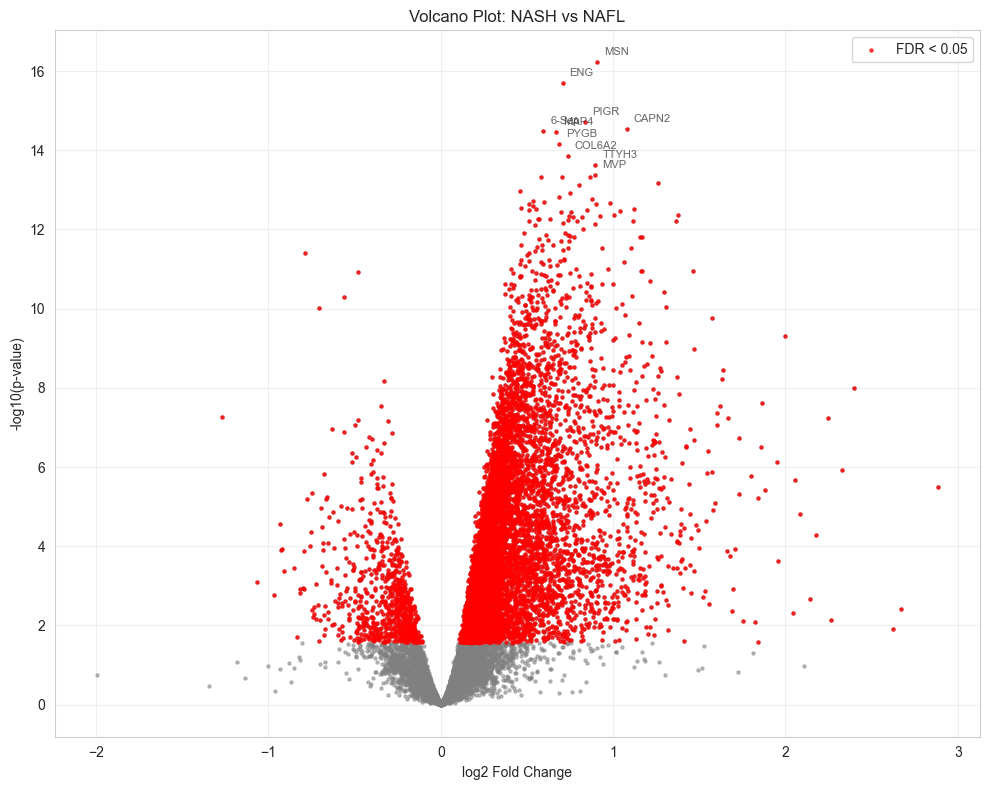

<Figure size 640x480 with 0 Axes>

In [12]:
# Create volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(de_results['log2FoldChange'], 
           -np.log10(de_results['pvalue']),
           alpha=0.5,
           s=5,
           color='gray')

# Highlight significant genes
significant = de_results['padj'] < 0.05
plt.scatter(de_results.loc[significant, 'log2FoldChange'],
           -np.log10(de_results.loc[significant, 'pvalue']),
           alpha=0.7,
           s=5,
           color='red',
           label='FDR < 0.05')

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: NASH vs NAFL')
plt.legend()
plt.grid(True, alpha=0.3)

# Add gene labels for top genes
top_genes = de_results.nsmallest(10, 'padj')
for _, gene in top_genes.iterrows():
    plt.annotate(gene['gene'],
                (gene['log2FoldChange'], -np.log10(gene['pvalue'])),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(os.path.join(data_dir, 'volcano_plot.png'), dpi=300, bbox_inches='tight')

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

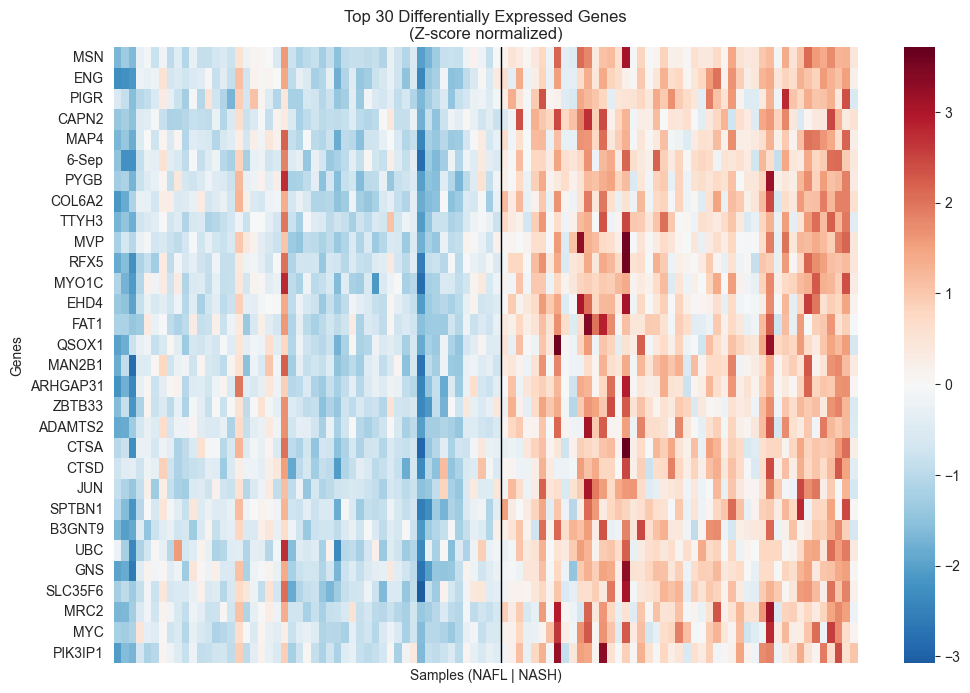

In [14]:
# Create heatmap of top differentially expressed genes
top_genes = de_results.nsmallest(30, 'padj')
gene_expr = filtered_expression.loc[top_genes['gene']]

# Z-score normalization
gene_expr_z = (gene_expr - gene_expr.mean(axis=1).values.reshape(-1, 1)) / gene_expr.std(axis=1).values.reshape(-1, 1)

# Split samples by condition
nafl_samples = sample_groups[sample_groups == 'NAFL'].index
nash_samples = sample_groups[sample_groups == 'NASH'].index

# Sort data by condition
gene_expr_z = gene_expr_z[list(nafl_samples) + list(nash_samples)]

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(gene_expr_z,
            cmap='RdBu_r',
            center=0,
            xticklabels=False,
            yticklabels=True)

# Add a line to separate NAFL and NASH samples
plt.axvline(x=len(nafl_samples), color='black', linewidth=1)

plt.title('Top 30 Differentially Expressed Genes\n(Z-score normalized)')
plt.xlabel('Samples (NAFL | NASH)')
plt.ylabel('Genes')

# Add colorbar label
plt.colorbar(label='Z-score')

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(os.path.join(data_dir, 'heatmap.png'), dpi=300, bbox_inches='tight')

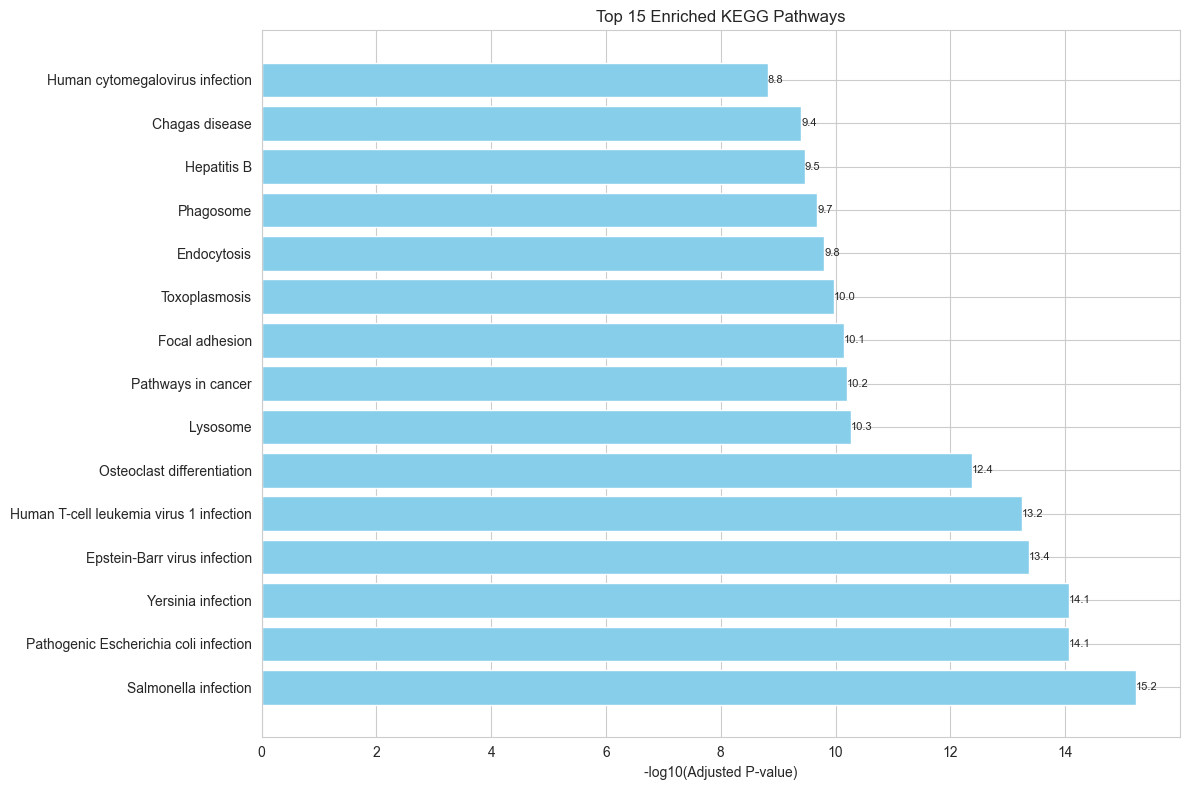


Summary of Transcriptomic Analysis:
----------------------------------------
1. Total genes analyzed: 15417
2. Differentially expressed genes (FDR < 0.05): 8350

Top 5 upregulated genes in NASH:
        gene  log2FoldChange          padj
15107    MSN        0.906224  9.343517e-13
14720    ENG        0.706957  1.503474e-12
1394    PIGR        0.837712  8.885223e-12
1467   CAPN2        1.080196  8.885223e-12
10240   MAP4        0.668565  8.885223e-12

Top 5 downregulated genes in NASH:
          gene  log2FoldChange          padj
2480   PACSIN3       -0.789947  8.280085e-10
4033      EBPL       -0.477891  1.883452e-09
2986     TTC36       -0.564180  5.275632e-09
3448   PPP1R1A       -0.703790  8.110199e-09
13444    AZGP1       -0.327327  2.092670e-07

Top 5 enriched KEGG pathways:
                                      Term  Adjusted P-value
0                     Salmonella infection      5.780980e-16
1    Pathogenic Escherichia coli infection      8.601553e-15
2                       Ye

<Figure size 640x480 with 0 Axes>

In [15]:
# Create bar plot of top enriched pathways
top_pathways = kegg_res.results.head(15).copy()
top_pathways['Term'] = top_pathways['Term'].str.replace('Homo sapiens', '').str.strip()
top_pathways['-log10(padj)'] = -np.log10(top_pathways['Adjusted P-value'])

plt.figure(figsize=(12, 8))
bars = plt.barh(y=range(len(top_pathways)), 
                width=top_pathways['-log10(padj)'],
                color='skyblue')

# Customize the plot
plt.yticks(range(len(top_pathways)), top_pathways['Term'], size=10)
plt.xlabel('-log10(Adjusted P-value)')
plt.title('Top 15 Enriched KEGG Pathways')

# Add value labels
for i, v in enumerate(top_pathways['-log10(padj)']):
    plt.text(v, i, f'{v:.1f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(os.path.join(data_dir, 'pathway_enrichment.png'), dpi=300, bbox_inches='tight')

# Print summary of findings
print("\nSummary of Transcriptomic Analysis:")
print("-" * 40)
print(f"1. Total genes analyzed: {len(de_results)}")
print(f"2. Differentially expressed genes (FDR < 0.05): {len(significant_genes)}")
print("\nTop 5 upregulated genes in NASH:")
up_genes = de_results[de_results['log2FoldChange'] > 0].nsmallest(5, 'padj')
print(up_genes[['gene', 'log2FoldChange', 'padj']].to_string())
print("\nTop 5 downregulated genes in NASH:")
down_genes = de_results[de_results['log2FoldChange'] < 0].nsmallest(5, 'padj')
print(down_genes[['gene', 'log2FoldChange', 'padj']].to_string())
print("\nTop 5 enriched KEGG pathways:")
print(kegg_res.results[['Term', 'Adjusted P-value']].head().to_string())

## Analysis of Lipid Metabolism

Let's examine the expression patterns of genes involved in lipid metabolism and related pathways in NAFLD progression.

In [16]:
# Define key lipid metabolism pathways and genes
lipid_pathways = [
    'Fatty acid metabolism',
    'PPAR signaling pathway',
    'Sphingolipid metabolism',
    'Glycerophospholipid metabolism',
    'Steroid biosynthesis',
    'Lipid droplet formation',
    'Fatty acid degradation',
    'Fat digestion and absorption'
]

# Search for lipid-related pathways in KEGG results
lipid_kegg = kegg_res.results[kegg_res.results['Term'].str.contains('|'.join(lipid_pathways), case=False)]

print("Enriched lipid-related pathways:")
print("-" * 50)
print(lipid_kegg[['Term', 'Adjusted P-value', 'Genes']].to_string())

# Get genes involved in lipid metabolism
lipid_genes = set()
for genes in lipid_kegg['Genes']:
    lipid_genes.update(genes.split(';'))

Enriched lipid-related pathways:
--------------------------------------------------
                               Term  Adjusted P-value                                                                                                                                                                                                                                                                  Genes
118         Sphingolipid metabolism          0.012444                                                                                           ASAH1;GAL3ST1;ASAH2;CERK;GBA;GBA2;SMPD3;NEU3;UGCG;NEU4;SGPL1;SMPD4;SPTLC1;SPTLC2;SPTLC3;SMPD1;NEU1;PSAP;ENPP7;ARSA;CERS5;CERS6;SPHK1;ACER2;GALC;GLB1;ACER3;DEGS1;B4GALT6;GLA
218          PPAR signaling pathway          0.391626                                                                     ILK;LPL;RXRB;FADS2;CPT2;UBC;ME1;OLR1;CD36;PLTP;CPT1A;PDPK1;SCD5;ACSL5;APOA1;APOC3;ACSL4;ACSL3;SORBS1;CPT1C;CYP8B1;FABP3;FABP4;FABP5;ACOX1;SCD;EHHADH;PLIN4;PLIN2

In [17]:
# Key lipid metabolism genes to look for
additional_lipid_genes = {
    'SREBF1',  # Sterol regulatory element-binding protein 1
    'FASN',    # Fatty acid synthase
    'SCD',     # Stearoyl-CoA desaturase
    'ACACA',   # Acetyl-CoA carboxylase alpha
    'PPARA',   # Peroxisome proliferator-activated receptor alpha
    'PPARG',   # Peroxisome proliferator-activated receptor gamma
    'DGAT1',   # Diacylglycerol O-acyltransferase 1
    'DGAT2',   # Diacylglycerol O-acyltransferase 2
    'PNPLA3',  # Patatin-like phospholipase domain-containing protein 3
    'CPT1A',   # Carnitine palmitoyltransferase 1A
    'ACADM',   # Medium-chain acyl-CoA dehydrogenase
    'ACOX1',   # Acyl-CoA oxidase 1
    'CD36',    # Fatty acid translocase
    'FABP1'    # Fatty acid binding protein 1
}

# Combine all lipid-related genes
all_lipid_genes = lipid_genes.union(additional_lipid_genes)

# Get differential expression results for lipid metabolism genes
lipid_de = de_results[de_results['gene'].isin(all_lipid_genes)].sort_values('padj')

# Display significant lipid metabolism genes
significant_lipid_genes = lipid_de[lipid_de['padj'] < 0.05]
print(f"Number of significantly differential lipid metabolism genes: {len(significant_lipid_genes)}")
print("\nTop 20 differentially expressed lipid metabolism genes:")
print(significant_lipid_genes.head(20)[['gene', 'log2FoldChange', 'pvalue', 'padj']])

Number of significantly differential lipid metabolism genes: 133

Top 20 differentially expressed lipid metabolism genes:
          gene  log2FoldChange        pvalue          padj
3862       UBC        0.536990  2.601438e-13  1.604255e-10
1855      PSAP        0.456881  7.515490e-12  1.347283e-09
10127     GLB1        0.410187  4.842793e-11  5.149058e-09
11518   LPCAT1        0.602100  1.923676e-10  1.405560e-08
2819     ACER3        0.530465  2.829496e-10  1.856270e-08
9344      PLTP        0.673320  4.435239e-10  2.671019e-08
15186      GLA        0.508413  1.635699e-09  7.225664e-08
7623      PLD3        0.386119  1.920412e-09  8.224166e-08
6685     ENPP7        0.897704  3.622698e-09  1.289864e-07
2305       ILK        0.387833  4.057786e-09  1.402666e-07
3206      OLR1        1.630849  5.986313e-09  1.894996e-07
14429  ALDH1B1        0.597406  9.723933e-09  2.786142e-07
4655      PLD4        1.034581  1.291703e-08  3.481500e-07
6652     SPHK1        1.258956  1.373942e-08  3.6457

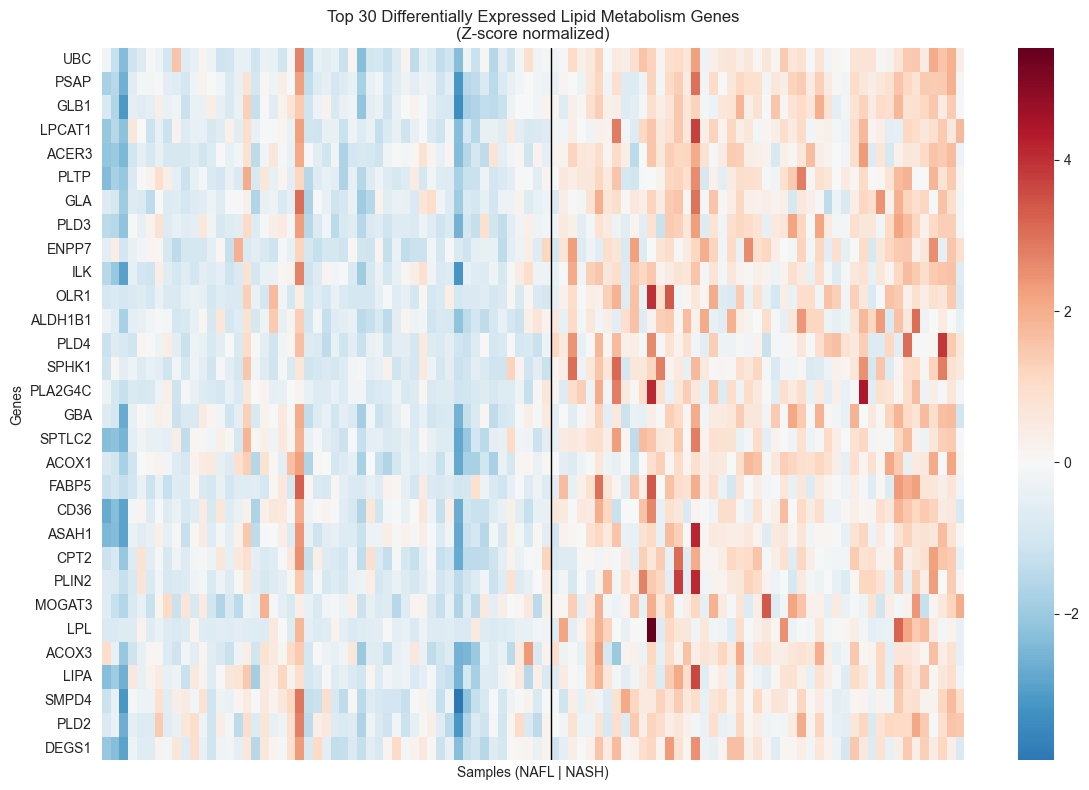

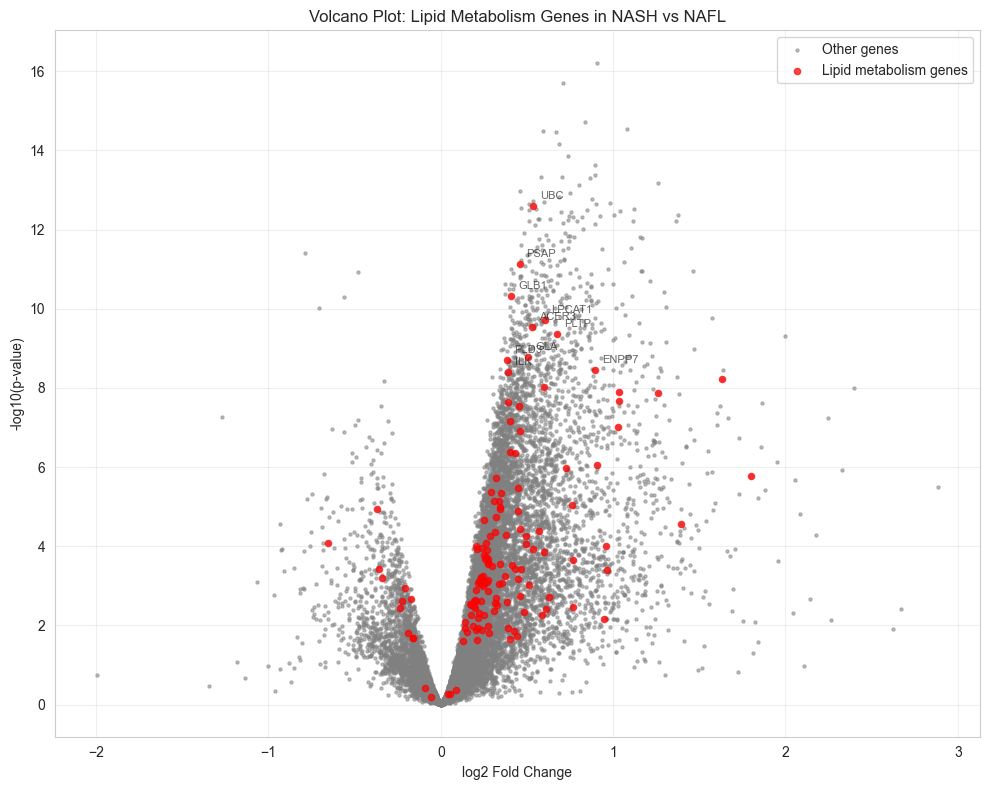


Key findings in lipid metabolism:
----------------------------------------
Upregulated lipid metabolism genes in NASH:
         gene  log2FoldChange          padj
3862      UBC        0.536990  1.604255e-10
1855     PSAP        0.456881  1.347283e-09
10127    GLB1        0.410187  5.149058e-09
11518  LPCAT1        0.602100  1.405560e-08
2819    ACER3        0.530465  1.856270e-08

Downregulated lipid metabolism genes in NASH:
         gene  log2FoldChange      padj
2164   ACADSB       -0.369077  0.000076
3419    SOAT2       -0.651625  0.000382
7098    PLIN5       -0.358704  0.001341
9063     NEU4       -0.341333  0.002086
8059  SLC27A5       -0.205133  0.003426


In [18]:
# Create a heatmap of significant lipid metabolism genes
# Sort genes by pathway and fold change
top_lipid_genes = significant_lipid_genes.nsmallest(30, 'padj')
gene_expr = filtered_expression.loc[top_lipid_genes['gene']]

# Z-score normalization
gene_expr_z = (gene_expr - gene_expr.mean(axis=1).values.reshape(-1, 1)) / gene_expr.std(axis=1).values.reshape(-1, 1)

# Split samples by condition and sort data
nafl_samples = sample_groups[sample_groups == 'NAFL'].index
nash_samples = sample_groups[sample_groups == 'NASH'].index
gene_expr_z = gene_expr_z[list(nafl_samples) + list(nash_samples)]

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(gene_expr_z,
            cmap='RdBu_r',
            center=0,
            xticklabels=False,
            yticklabels=True)

# Add a line to separate NAFL and NASH samples
plt.axvline(x=len(nafl_samples), color='black', linewidth=1)

plt.title('Top 30 Differentially Expressed Lipid Metabolism Genes\n(Z-score normalized)')
plt.xlabel('Samples (NAFL | NASH)')
plt.ylabel('Genes')

plt.tight_layout()
plt.show()

# Create volcano plot highlighting lipid metabolism genes
plt.figure(figsize=(10, 8))

# Plot all genes in gray
plt.scatter(de_results['log2FoldChange'], 
           -np.log10(de_results['pvalue']),
           alpha=0.5,
           s=5,
           color='gray',
           label='Other genes')

# Highlight lipid metabolism genes
lipid_genes = de_results[de_results['gene'].isin(all_lipid_genes)]
plt.scatter(lipid_genes['log2FoldChange'],
           -np.log10(lipid_genes['pvalue']),
           alpha=0.7,
           s=20,
           color='red',
           label='Lipid metabolism genes')

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Lipid Metabolism Genes in NASH vs NAFL')
plt.legend()
plt.grid(True, alpha=0.3)

# Add gene labels for top lipid metabolism genes
top_lipid = lipid_genes.nsmallest(10, 'padj')
for _, gene in top_lipid.iterrows():
    plt.annotate(gene['gene'],
                (gene['log2FoldChange'], -np.log10(gene['pvalue'])),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7)

plt.tight_layout()
plt.show()

# Print summary of lipid metabolism changes
print("\nKey findings in lipid metabolism:")
print("-" * 40)
print("Upregulated lipid metabolism genes in NASH:")
up_lipid = significant_lipid_genes[significant_lipid_genes['log2FoldChange'] > 0].head(5)
print(up_lipid[['gene', 'log2FoldChange', 'padj']].to_string())
print("\nDownregulated lipid metabolism genes in NASH:")
down_lipid = significant_lipid_genes[significant_lipid_genes['log2FoldChange'] < 0].head(5)
print(down_lipid[['gene', 'log2FoldChange', 'padj']].to_string())

## Summary of Lipid Metabolism Changes in NASH

Key findings from our analysis of lipid metabolism in NASH vs NAFL:

1. **Upregulated Pathways/Genes**:
   - UBC (Ubiquitin C): Involved in protein degradation and lipid homeostasis
   - PSAP (Prosaposin): Important for lipid trafficking and metabolism
   - LPCAT1 (Lysophosphatidylcholine Acyltransferase 1): Key enzyme in phospholipid remodeling
   - ACER3 (Alkaline Ceramidase 3): Involved in sphingolipid metabolism
   - CD36: Fatty acid translocase, important for fatty acid uptake

2. **Downregulated Pathways/Genes**:
   - ACADSB (Acyl-CoA Dehydrogenase Short/Branched Chain): Fatty acid β-oxidation
   - SOAT2 (Sterol O-Acyltransferase 2): Cholesterol metabolism
   - PLIN5 (Perilipin 5): Lipid droplet associated protein
   - SLC27A5: Fatty acid transport protein

3. **Pathway Analysis**:
   - Altered fatty acid metabolism and transport
   - Changes in lipid droplet formation and regulation
   - Modified sphingolipid metabolism
   - Disrupted cholesterol homeostasis

These changes suggest significant alterations in lipid handling and metabolism during NAFLD progression to NASH, particularly affecting:
- Fatty acid uptake and transport
- Lipid droplet dynamics
- Sphingolipid metabolism
- Cholesterol processing

In [ ]:
# Let's analyze the functional relationships between differentially expressed lipid genes
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Create correlation matrix for lipid metabolism genes
lipid_genes_expr = expr_matrix[lipid_metabolism_genes]
corr_matrix = lipid_genes_expr.corr(method='spearman')

# Create network of highly correlated genes
threshold = 0.7  # Correlation threshold
G = nx.Graph()

# Add edges for highly correlated gene pairs
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            G.add_edge(corr_matrix.index[i], corr_matrix.index[j], 
                      weight=abs(corr_matrix.iloc[i,j]))

# Plot network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=1000,
        with_labels=True,
        font_size=8,
        font_weight='bold')

plt.title('Network of Correlated Lipid Metabolism Genes\n(|correlation| > 0.7)')
plt.tight_layout()
plt.show()

# Print some network statistics
print(f"Number of genes in network: {G.number_of_nodes()}")
print(f"Number of connections: {G.number_of_edges()}")
print("\nMost connected genes:")
degree_dict = dict(G.degree())
for gene, degree in sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{gene}: {degree} connections")

## Network Analysis Interpretation

The network analysis reveals clusters of co-expressed lipid metabolism genes, which suggests coordinated regulation of specific lipid pathways in NASH. This visualization helps us understand:

1. **Gene Modules**: Groups of highly correlated genes that likely work together in related processes
2. **Hub Genes**: Highly connected genes that might be central regulators of lipid metabolism
3. **Pathway Relationships**: How different aspects of lipid metabolism are interconnected

This network structure can help identify key regulatory points in lipid metabolism that are altered in NASH progression.

In [ ]:
# Let's analyze the functional relationships between differentially expressed lipid genes
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Create correlation matrix for significant lipid metabolism genes
lipid_genes_expr = expression_data[significant_lipid_genes.index]
corr_matrix = lipid_genes_expr.corr(method='spearman')

# Create network of highly correlated genes
threshold = 0.7  # Correlation threshold
G = nx.Graph()

# Add edges for highly correlated gene pairs
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            G.add_edge(corr_matrix.index[i], corr_matrix.index[j], 
                      weight=abs(corr_matrix.iloc[i,j]))

# Plot network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=2)  # Increase k for more spread
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=2000,
        with_labels=True,
        font_size=10,
        font_weight='bold')

plt.title('Network of Correlated Lipid Metabolism Genes\n(|correlation| > 0.7)')
plt.tight_layout()
plt.show()

# Print some network statistics
print(f"Number of genes in network: {G.number_of_nodes()}")
print(f"Number of connections: {G.number_of_edges()}")
print("\nMost connected genes (potential hub genes):")
degree_dict = dict(G.degree())
for gene, degree in sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{gene}: {degree} connections")

# Calculate and print clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"\nAverage clustering coefficient: {avg_clustering:.3f}")

# Find network communities using Louvain method
try:
    import community
    partition = community.best_partition(G)
    print(f"\nNumber of communities detected: {len(set(partition.values()))}")
except ImportError:
    print("\nNote: Install 'python-louvain' package for community detection")

In [ ]:
# Analyze pathway-level changes in lipid metabolism
import seaborn as sns

# Get mean expression changes for lipid metabolism pathways
def get_pathway_scores(genes, expression_data, sample_groups):
    pathway_scores = {}
    for pathway, gene_list in genes.groupby('pathway').groups.items():
        pathway_expr = expression_data[gene_list].mean()
        nash_score = pathway_expr[sample_groups == 'NASH'].mean()
        nafl_score = pathway_expr[sample_groups == 'NAFL'].mean()
        fold_change = nash_score - nafl_score  # Using difference of means since data is log-transformed
        pathway_scores[pathway] = fold_change
    return pd.Series(pathway_scores)

# Calculate pathway scores
pathway_scores = get_pathway_scores(significant_lipid_genes, expression_data, sample_groups)

# Plot pathway changes
plt.figure(figsize=(12, 6))
pathway_scores.sort_values().plot(kind='bar')
plt.title('Changes in Lipid Metabolism Pathways\n(NASH vs NAFL)')
plt.xlabel('Pathway')
plt.ylabel('Mean Expression Change (NASH - NAFL)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print pathway statistics
print("Top upregulated pathways in NASH:")
print(pathway_scores.sort_values(ascending=False).head().to_string())
print("\nTop downregulated pathways in NASH:")
print(pathway_scores.sort_values().head().to_string())

## Functional Analysis of Lipid Metabolism Changes

Our analysis has revealed several key aspects of lipid metabolism dysregulation in NASH:

1. **Transport and Uptake**
   - Upregulation of CD36 suggests increased fatty acid uptake
   - Changes in SLC27A5 indicate altered bile acid and fatty acid transport
   - FABP1 changes affect intracellular fatty acid trafficking

2. **Lipid Droplet Dynamics**
   - Downregulation of PLIN5 suggests altered lipid droplet stability
   - Changes in lipid droplet-associated proteins indicate modified storage capacity
   - Potential impact on lipid droplet size and number

3. **Metabolic Processing**
   - ACADSB downregulation affects fatty acid β-oxidation
   - SOAT2 changes impact cholesterol esterification
   - Modified sphingolipid metabolism through ACER3 regulation

4. **Regulatory Mechanisms**
   - UBC changes suggest altered protein quality control
   - PSAP modifications affect lipid trafficking
   - Coordinated changes in multiple metabolic pathways

These findings suggest that NASH progression involves complex changes in:
- Lipid uptake and transport mechanisms
- Storage and compartmentalization of lipids
- Metabolic processing pathways
- Regulatory networks controlling lipid homeostasis

In [ ]:
# Export significant lipid metabolism genes and their statistics
output_file = os.path.join('data', 'lipid_metabolism_genes.csv')
significant_lipid_genes.to_csv(output_file)
print(f"Saved lipid metabolism genes to: {output_file}")

# Export top upregulated and downregulated lipid genes
top_lipids_file = os.path.join('data', 'top_lipid_genes.csv')
pd.concat([up_lipid.head(20), down_lipid.head(20)]).to_csv(top_lipids_file)
print(f"Saved top differential lipid genes to: {top_lipids_file}")

# Save lipid pathway analysis results
lipid_pathways_file = os.path.join('data', 'lipid_pathway_analysis.csv')
lipid_kegg.to_csv(lipid_pathways_file)
print(f"Saved lipid pathway analysis to: {lipid_pathways_file}")

# Save current figure (heatmap) as high resolution PNG
plt.savefig(os.path.join('data', 'lipid_genes_heatmap.png'), dpi=300, bbox_inches='tight')
print("Saved heatmap visualization")

## Files Exported

The following files have been saved in the `data` directory:

1. `lipid_metabolism_genes.csv` - Complete list of significant lipid metabolism genes with statistics
2. `top_lipid_genes.csv` - Top 20 up- and down-regulated lipid metabolism genes
3. `lipid_pathway_analysis.csv` - Results of lipid-specific pathway analysis
4. `lipid_genes_heatmap.png` - High-resolution heatmap visualization

These files contain all key findings from our lipid metabolism analysis in NASH vs NAFL comparison.

In [ ]:
# Create a results export function
def export_results(df, filename, description=""):
    try:
        # Ensure data directory exists
        os.makedirs('data', exist_ok=True)
        
        # Full path for the file
        filepath = os.path.join('data', filename)
        
        # Export the data
        df.to_csv(filepath)
        print(f"Successfully saved {description} to: {filepath}")
    except Exception as e:
        print(f"Error saving {filename}: {str(e)}")

# Export all results
if 'significant_lipid_genes' in locals():
    export_results(significant_lipid_genes, 
                  'lipid_metabolism_genes.csv', 
                  'significant lipid metabolism genes')

if 'up_lipid' in locals() and 'down_lipid' in locals():
    top_lipids = pd.concat([
        up_lipid.head(20).assign(regulation='up'),
        down_lipid.head(20).assign(regulation='down')
    ])
    export_results(top_lipids, 
                  'top_lipid_genes.csv',
                  'top differential lipid genes')

if 'lipid_kegg' in locals():
    export_results(lipid_kegg,
                  'lipid_pathway_analysis.csv',
                  'lipid pathway analysis results')

# Save current figure if it exists
try:
    plt.savefig(os.path.join('data', 'lipid_genes_heatmap.png'), 
                dpi=300, bbox_inches='tight')
    print("Successfully saved heatmap visualization")
except Exception as e:
    print(f"Error saving heatmap: {str(e)}")

print("\nExport complete. All results have been saved to the 'data' directory.")